In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [42]:
def analyze_encoding(name, results_path):
    df = pd.read_csv(results_path, index_col=[0, 1])
    
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.boxplot(x="subject", y="value", hue="type", data=df.reset_index().melt(id_vars=["subject", "type"], value_vars=["mar_fold_%i" % i for i in range(18)]), ax=ax)
    plt.ylim((40, 260))
    plt.ylabel("average rank")
    
    subj_perf = df.groupby("type").apply(lambda sub_df: sub_df.reset_index(drop=True).mean(axis=1)).T
    subj_perf.plot.bar(title="Within-subject MAR")
    
    return subj_perf.agg(["mean", "sem"])

In [44]:
stats = {}

,ridge,ridge_permute
mean,141.628968,200.717923
sem,7.497662,1.670000


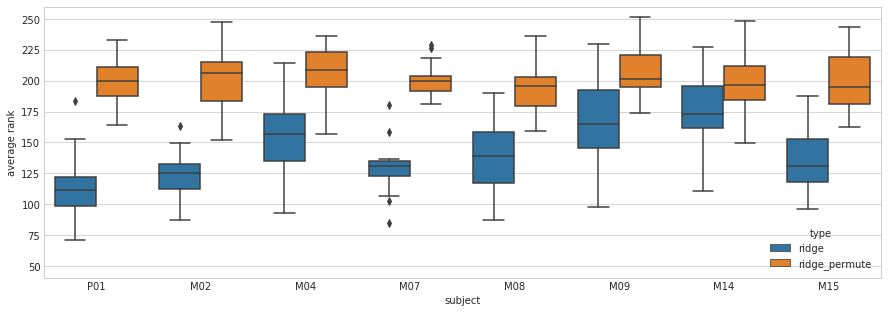

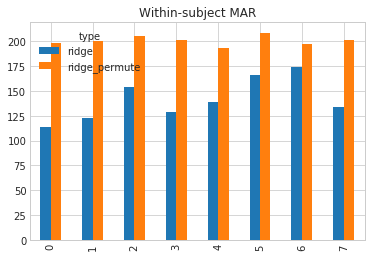

In [46]:
stats["fairseq"] = analyze_encoding("fairseq", "perf.384sentences.fairseq.wmt14.en-fr.fconv.dim256.csv")
stats["fairseq"]

------------

,ridge,ridge_permute
mean,116.201058,196.903108
sem,9.730405,3.006739


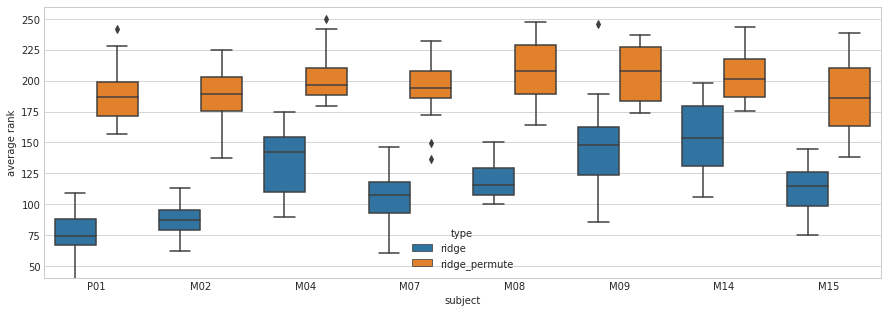

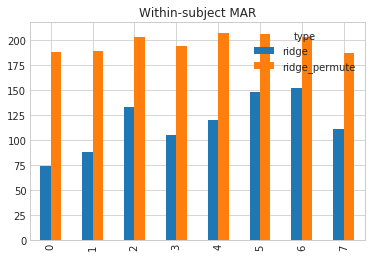

In [47]:
stats["infersent"] = analyze_encoding("infersent", "perf.384sentences.infersent.allnli.dim256.csv")
stats["infersent"]

-------------

,ridge,ridge_permute
mean,189.200397,190.514881
sem,1.413756,2.015589


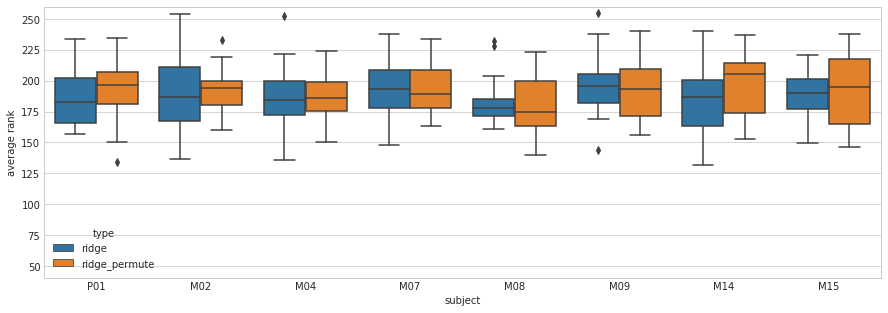

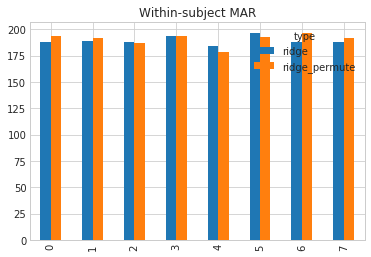

In [48]:
stats["imdb"] = analyze_encoding("imdb", "perf.384sentences.imdbsentiment.dim128.csv")
stats["imdb"]

---------

,ridge,ridge_permute
mean,111.486442,190.250331
sem,10.799408,2.730786


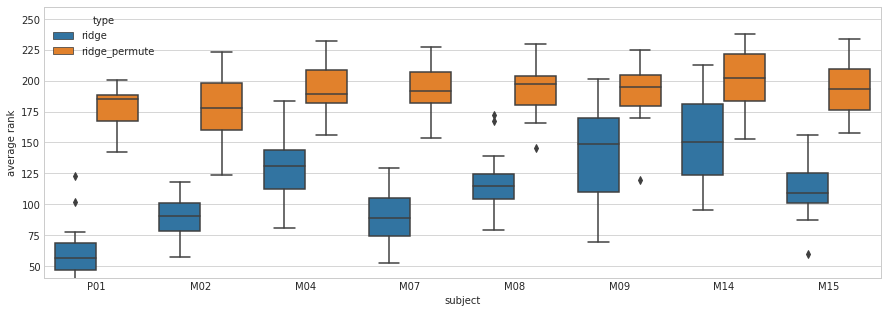

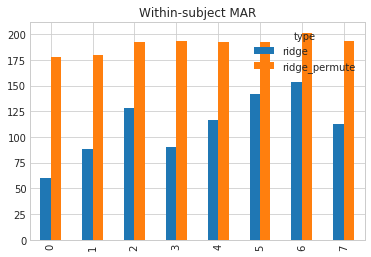

In [49]:
stats["skipthought"] = analyze_encoding("skipthought", "perf.384sentences.skipthought.dim256.csv")
stats["skipthought"]

Text(0,0.5,'average rank')

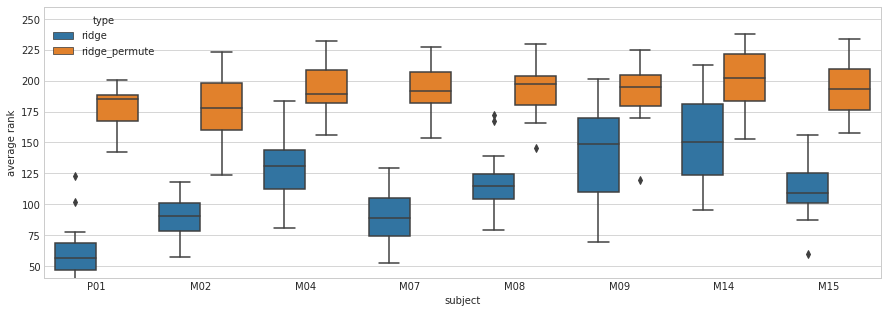

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="subject", y="value", hue="type", data=df.reset_index().melt(id_vars=["subject", "type"], value_vars=["mar_fold_%i" % i for i in range(18)]), ax=ax)
plt.ylim((40, 260))
plt.ylabel("average rank")

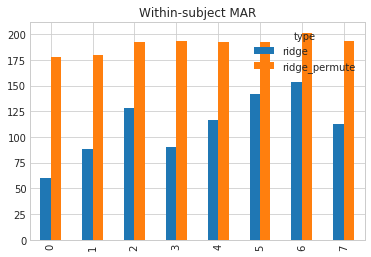

In [35]:
subj_perf = df.groupby("type").apply(lambda sub_df: sub_df.reset_index(drop=True).mean(axis=1)).T
subj_perf.plot.bar(title="Within-subject MAR")

---------

[-0.25  0.75  1.75  2.75  0.  ]


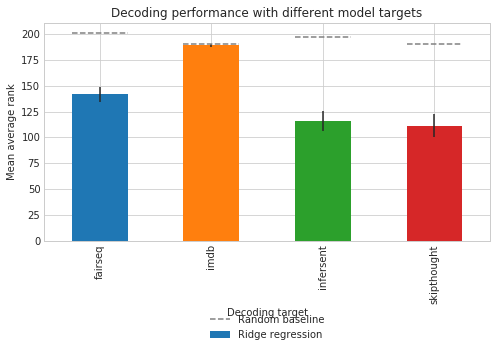

In [62]:
fig, ax = plt.subplots(figsize=(8,4))
f = pd.concat(stats, names=["target", "metric"]).reset_index("metric")
means = f[f["metric"] == "mean"]["ridge"]
random_means = f[f["metric"] == "mean"]["ridge_permute"]
stderrs = f[f["metric"] == "sem"]["ridge"]
means.plot.bar(yerr=stderrs, ax=ax, label="Ridge regression")
plt.xlabel("Decoding target")
plt.ylabel("Mean average rank")
plt.title("Decoding performance with different model targets")

import matplotlib
bars = [child for child in ax.get_children() if isinstance(child, matplotlib.patches.Rectangle)]
baselines_start = np.array([plt.getp(item, "x") for item in bars])
baselines_end = baselines_start + np.array([plt.getp(item, "width") for item in bars])
print(baselines_start)
plt.hlines(random_means, baselines_start[:-1], baselines_end[:-1], colors="gray", linestyles="dashed", label="Random baseline")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3))